# Exogenous Process modeling 

## OHM price stochastic process

1. Acquire hourly OHM/DAI data from Sushiswap.

'https://api.thegraph.com/subgraphs/name/sushiswap/exchange'

"""
query {
    pair(id: "0x34d7d7aaf50ad4944b70b320acb24c95fa2def7c") {
    hourData(first: 1000, skip:{}) {
      date
      reserve0
      reserve1
    }
  }
 }
"""

2. Fit a parametric distribution to the price of OHM, gamma + Kalman fit (prediction) resulting in a distribution $F^p_{OHM}(t; \mu_{OHM})$ and fitted parameters $\mu_{OHM}$.


In [1]:
# import libraries
import pandas as pd
import numpy as np
from scipy.stats import gamma
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

## Data preprocessing

In [2]:
# import data
historical_ohm_hourly = pd.read_csv('data/sushi_ohm_hourly.csv')
historical_ohm_hourly['price'] = historical_ohm_hourly['reserve1'] / historical_ohm_hourly['reserve0']
historical_ohm_hourly.head(5)

,Unnamed: 0,date,reserve0,reserve1,price
0,0,1616461200,2356.125551,5.809582e+05,246.573550
1,1,1616464800,2080.455537,9.678865e+05,465.228148
2,2,1616468400,2519.150524,1.003628e+06,398.399355
3,3,1616472000,2687.683376,9.425800e+05,350.703515
4,4,1616475600,2798.322299,9.060020e+05,323.766145


In [4]:
historical_ohm_hourly['Date'] = pd.to_datetime(historical_ohm_hourly['date'], unit='s')
#historical_ohm_hourly = historical_eth_hourly[historical_eth_hourly['Date']>'2017-01-01']

In [5]:
# sort by date from earliest to latest
sorted_historical_ohm_hourly = historical_ohm_hourly.sort_values(by='Date')

In [6]:
# split into training and test data. 
train, test= np.split(sorted_historical_ohm_hourly, [int(.9 *len(sorted_historical_ohm_hourly))])

In [7]:
train.tail()

,Unnamed: 0,date,reserve0,reserve1,price,Date
5013,5013,1634547600,139696.849769,1.133346e+08,811.289710,2021-10-18 09:00:00
5014,5014,1634551200,140120.033444,1.129962e+08,806.424368,2021-10-18 10:00:00
5015,5015,1634554800,140061.900423,1.130450e+08,807.107590,2021-10-18 11:00:00
5016,5016,1634558400,141517.807310,1.118897e+08,790.640749,2021-10-18 12:00:00
5017,5017,1634562000,143317.798286,1.111852e+08,775.794491,2021-10-18 13:00:00


<AxesSubplot:title={'center':'OHM Hourly data'}, xlabel='Date'>

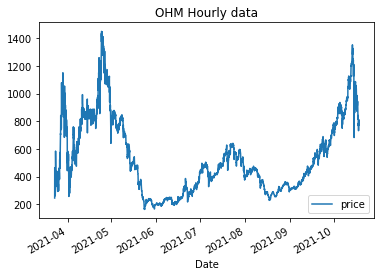

In [8]:
train.plot(x='Date',y='price',title='OHM Hourly data')

## Kalman filter

Kalman filters are a lightweight algorithm often in an economic context for reducing noise in signals. The Kalman Filter is trained on a subset of the data, and then the parameters are passed into a prediction function for use in subsequent samples. As Kalman filters are one step predictors, at each time step, the filters is retrained and the system state and parameters are updated. 

This implemention was refined by Andrew Clark in a [recent paper](https://ideas.repec.org/p/rdg/emxxdp/em-dp2020-22.html) that used Kalman filters embedded into a cadCAD model for forecasting exchange rates.

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import gamma

def kalman_filter(observations,initialValue,truthValues=None,plot=False,paramExport=False):
    '''
    Description:
    Function to create a Kalman Filter for smoothing currency timestamps in order to search for the
    intrinisic value.
    
    Parameters:
    observations: Array of observations, i.e. predicted secondary market prices.
    initialValue: Initial Starting value of filter
    truthValues: Array of truth values, i.e. GPS location or secondary market prices. Or can be left
    blank if none exist
    plot: If True, plot the observations, truth values and kalman filter.
    paramExport: If True, the parameters xhat,P,xhatminus,Pminus,K are returned to use in training.
    
    Example:
    xhat,P,xhatminus,Pminus,K = kalman_filter(observations=train.Close.values[0:-1],
                                              initialValue=train.Close.values[-1],paramExport=True)
    '''
    # intial parameters
    n_iter = len(observations)
    sz = (n_iter,) # size of array
    if isinstance(truthValues,np.ndarray):
        x = truthValues # truth value
    z = observations# observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.5**2 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = initialValue
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    if plot==True:
        plt.figure()
        plt.plot(z,'k+',label='Actual data')
        plt.plot(xhat,'b-',label='a posteri estimate')
        if isinstance(truthValues,np.ndarray):
            plt.plot(x,color='g',label='truth value')
        plt.legend()
        plt.title('Kalman Filter Estimates', fontweight='bold')
        plt.xlabel('Iteration')
        plt.ylabel('USD')
        plt.show()

    if paramExport==True:
        return  xhat,P,xhatminus,Pminus,K

    else:

        return xhat

def kalman_filter_predict(xhat,P,xhatminus,Pminus,K,observations,truthValues=None,paramExport=False):
    '''
    Description:
    Function to predict a pre-trained Kalman Filter 1 step forward.
    
    Parameters:
    xhat: Trained Kalman filter values - array
    P: Trained Kalman variance - array
    xhatminus: Trained Kalman xhat delta - array
    Pminus: Trained Kalman variance delta - array
    K: Kalman gain - array
    observations: Array of observations, i.e. predicted secondary market prices.
    truthValues: Array of truth values, i.e. GPS location or secondary market prices. Or can be left
    blank if none exist
    paramExport: If True, the parameters xhat,P,xhatminus,Pminus,K are returned to use in next predicted step.
    
    Example:
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(xhatInput,PInput,
                                                      xhatminusInput,PminusInput,KInput,observation,
                                                       paramExport=True)
    '''
    # intial parameters
    if isinstance(truthValues,np.ndarray):
        x = truthValues # truth value
    z = observations# observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    R = 0.5**2 # estimate of measurement variance, change to see effect


    # time update
    xhatminus = np.append(xhatminus,xhat[-1])
    Pminus = np.append(Pminus,P[-1]+Q)

    # measurement update
    K = np.append(K,Pminus[-1]/( Pminus[-1]+R ))
    xhat = np.append(xhat,xhatminus[-1]+K[-1]*(z[-1]-xhatminus[-1]))
    P = np.append(P,(1-K[-1])*Pminus[-1])

    if paramExport==True:
        return  xhat,P,xhatminus,Pminus,K

    else:

        return xhat

## Process training

Fit the gamma distribution off of the training data.

In [10]:
timesteps = 24 * 365 # 24 hours a day * 365 days a year 
# fit ohm distribution
fit_shape, fit_loc, fit_scale = gamma.fit(train.price.values)
sample = np.random.gamma(fit_shape, fit_scale, 100)[0]
sample

115.20446218418796

Text(0.5, 1.0, 'Histogram of Ohm Price IID Samples')

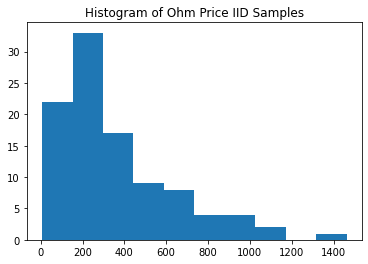

In [11]:
# generate 100 samples for initialization of Kalman
samples = np.random.gamma(fit_shape, fit_scale, 100)
plt.hist(samples)
plt.title('Histogram of Ohm Price IID Samples')

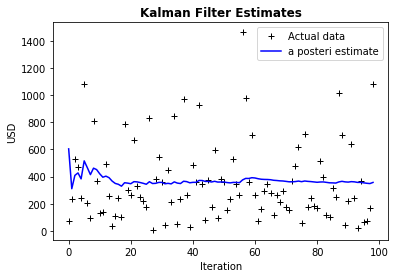

In [12]:
# train kalman
xhat,P,xhatminus,Pminus,K = kalman_filter(observations=samples[0:-1],
                                          initialValue=samples[-1],paramExport=True,plot=True)

## Validation

To test how our generator is working, we will make 100 predictions and compare to the test data.

In [13]:
ohm_values = []
filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}

for i in range(0,100):
    sample = np.random.gamma(fit_shape, fit_scale, 1)[0]
    ohm_values.append(sample)
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(filter_values['xhat'],
                                                  filter_values['P'],
                                                  filter_values['xhatminus'],
                                                  filter_values['Pminus'],
                                                  filter_values['K'],
                                                  ohm_values,
                                                  paramExport=True)
    filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}
                                                                    

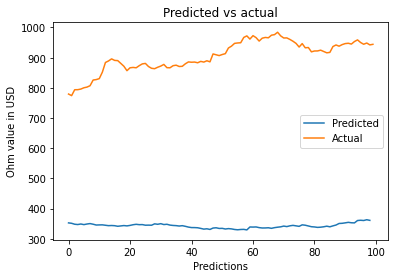

In [14]:
plt.plot(xhat[100:], label = 'Predicted')
plt.plot(test.head(100)['price'].values, label = 'Actual')
plt.xlabel('Predictions')
plt.ylabel('Ohm value in USD')
# Set a title of the current axes.
plt.title('Predicted vs actual')
plt.legend()
# Display a figure.
plt.show()

## Generate data for simulation

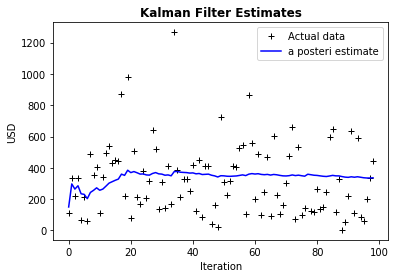

In [15]:
samples = np.random.gamma(fit_shape, fit_scale, 100)
# train kalman
xhat,P,xhatminus,Pminus,K = kalman_filter(observations=samples[0:-1],
                                          initialValue=samples[-1],paramExport=True,plot=True)

In [16]:
ohm_values = []
filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}

for i in range(0,timesteps+1):
    sample = np.random.gamma(fit_shape, fit_scale, 1)[0]
    ohm_values.append(sample)
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(filter_values['xhat'],
                                                  filter_values['P'],
                                                  filter_values['xhatminus'],
                                                  filter_values['Pminus'],
                                                  filter_values['K'],
                                                  ohm_values,
                                                  paramExport=True)
    filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}
                                                                    

Text(0.5, 1.0, 'Histogram of Ohm Price IID Samples')

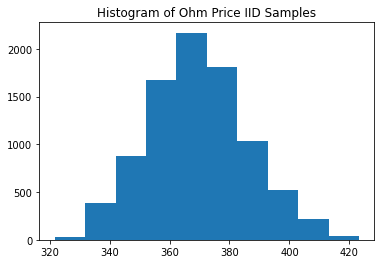

In [17]:
plt.hist(xhat[100:])
plt.title('Histogram of Ohm Price IID Samples')

Text(0.5, 1.0, 'Predicted Ohm Prices')

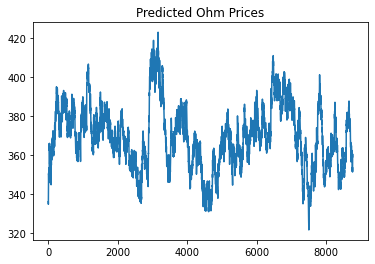

In [18]:
plt.plot(xhat[100:])
plt.title('Predicted Ohm Prices')

In [19]:
timesteps

8760

In [20]:
ohm_prices = pd.DataFrame(ohm_values,columns=['Ohm_price'])
ohm_prices.head()

,Ohm_price
0,437.980230
1,214.814734
2,310.400988
3,245.228039
4,764.910098


In [21]:
# export data
ohm_prices.to_csv('data/ohm_prices.csv')

### Generate Monte Carlo runs

In [24]:
def generate_timeseries(xhat, P, xhatminus, Pminus, K):
    values = []
    filter_values = {'xhat':xhat,'P':P,
                     'xhatminus':xhatminus,'Pminus':Pminus,
                     'K':K}

    for i in range(0,timesteps+1):
        sample = np.random.gamma(fit_shape, fit_scale, 1)[0]
        values.append(sample)
        xhat,P,xhatminus,Pminus,K = kalman_filter_predict(filter_values['xhat'],
                                                      filter_values['P'],
                                                      filter_values['xhatminus'],
                                                      filter_values['Pminus'],
                                                      filter_values['K'],
                                                      values,
                                                      paramExport=True)
        filter_values = {'xhat':xhat,'P':P,
                     'xhatminus':xhatminus,'Pminus':Pminus,
                     'K':K}

    return values, xhat, P, xhatminus, Pminus, K

In [26]:
monte_carlo_runs = 10

values_mc = {}
for run in range(0, monte_carlo_runs):
    np.random.seed(seed=run)
    
    buffer_for_transcients = 100
    samples = np.random.gamma(fit_shape, fit_scale, timesteps + buffer_for_transcients)
    # train kalman
    xhat,P,xhatminus,Pminus,K = kalman_filter(observations=samples[0:-1],
                                              initialValue=samples[-1],paramExport=True,plot=False)
    
    # values, _, _, _, _, _ = generate_eth_timeseries(xhat, P, xhatminus, Pminus, K)
    values_mc[run] = xhat[buffer_for_transcients:]
    
values, xhat, P, xhatminus, Pminus, K = generate_timeseries(xhat, P, xhatminus, Pminus, K)

values_mc_df = pd.DataFrame(values_mc)
values_mc_df.to_csv('data/ohm_values_mc.csv')
values_mc_df

,0,1,2,3,4,5,6,7,8,9
0,369.975786,365.520141,387.489349,361.415613,375.055865,382.694775,359.289777,348.480021,380.905669,370.397761
1,366.577325,362.283748,383.816302,365.402478,379.885429,380.685359,356.955712,347.215801,390.041575,371.998421
2,367.907081,362.524350,381.981187,363.809644,375.942401,380.511167,356.437053,351.042080,385.987388,368.655551
3,364.372579,361.497191,384.553270,363.512300,378.815847,383.988304,355.994407,351.272107,384.167432,371.266214
4,361.424096,359.352327,386.200657,362.728601,377.368954,380.973654,359.250384,349.001501,383.279523,367.572682
...,...,...,...,...,...,...,...,...,...,...
8754,370.907804,373.877905,352.199628,354.595755,326.967455,356.962592,379.760407,376.927346,349.391290,340.309486
8755,369.329254,371.548889,352.348264,352.762068,326.295362,357.355888,380.394031,376.021025,350.932059,340.131453
8756,368.672163,371.790928,350.392953,351.669775,325.756276,355.980868,383.863571,374.631493,349.156640,341.628756
8757,368.122745,370.918678,352.074123,351.356815,323.993457,354.652607,381.879524,372.802352,348.601646,341.752460


## Implementation information
Below is an example of how to integrate these univariate time series datasets into the exogenous process section of a cadCAD model, assuming each timestep is an hour.


```
    
# partial_state_update_block.py
partial_state_update_block = {
    # Exogenous
    'Exogenous': {
        'policies': {
        },
        'variables': {
            'eth_price': eth_price_mech,
        }
    },
    
# exogenousProcesses.py


# import libraries
import pandas as pd

# import data
eth_prices = pd.read_csv('data/eth_prices.csv')

# mechanisms
def eth_price_mech(params, step, sL, s, _input):
    y = 'eth_price'
    timestep = s['timestep'] 
    x = eth_prices.Eth_price.values[timestep]
    return (y, x)

    
```

## Conclusion

In this notebook, we've read in hourly historical eth data from kaggle, defined functions for fitting and making predictions off of a gamma distribution, which is comminly used in for random walk calculations, and defined functions for de-noising kalman filter. We then validated the structure of these functions and predicted 100 timesteps for evaluation and demonstration purposes. Finally, we provided an overview of how to fit this code into cadCAD. Next steps could include:
* Refining the Kalman filter hyperparameters
* Refining the gamma prediction tuning parameter
* More thorough model validation
* Add seasonality

